In [4]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from collections import OrderedDict
import pandas as pd
import csv

torch.set_printoptions(edgeitems=3, linewidth=75)

In [22]:
# load up data frame

wine_path = "./winequality-white.csv"
wineq_numpy = np.loadtxt(wine_path, dtype=np.float32, delimiter=";",
                         skiprows=1)
wineq = torch.from_numpy(wineq_numpy)

col_list = next(csv.reader(open(wine_path), delimiter=';'))
df = pd.DataFrame(wineq_numpy,columns=col_list) # for display
display(df.head()) # last column is wine rating on scale 1-9, this is what we predict

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.700001,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,6.3,0.30,0.34,1.600000,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,8.1,0.28,0.40,6.900000,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,7.2,0.23,0.32,8.500000,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


In [9]:
# extract data and normalize

data      = wineq[:, :-1]
data_mean = torch.mean(data, dim=0)
data_var  = torch.var( data, dim=0)
data_norm = (data - data_mean) / torch.sqrt(data_var)

target    = wineq[:,-1] # alternatively could one-hot code instead
targ_mean = torch.mean(target)
targ_var  = torch.var(target)
targ_norm = (target - targ_mean) / torch.sqrt(targ_var)


In [37]:
# making training vs validation data

n_samples = data.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

data_train = data_norm[train_indices]
targ_train = targ_norm[train_indices]
targ_train.unsqueeze_(1) # have to unsqueeze to prevent error I don't quite understand

data_val = data_norm[val_indices]
targ_val = targ_norm[val_indices]
targ_val.unsqueeze_(1)

print()



In [47]:
# basic training loop

def training_loop(n_epochs, optimizer, model, loss_fn,
                  data_train, data_val, targ_train, targ_val):
    
    for epoch in range(1, n_epochs + 1):
        pred_train = model(data_train) # <1>
        loss_train = loss_fn(pred_train, targ_train)

        pred_val = model(data_val) # <1>
        loss_val = loss_fn(pred_val, targ_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [48]:
nc = 16
model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(11, nc)), # there are 11 factors for each wine
    ('hidden_activation', nn.Tanh()),
    ('hidden_activation', nn.Tanh()),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(nc, 1))
]))

optimizer = optim.SGD(model.parameters(), lr=1e-2)

training_loop(
    n_epochs   = 100000, 
    optimizer  = optimizer,
    model      = model,
    loss_fn    = nn.MSELoss(),
    data_train = data_train,
    data_val   = data_val, 
    targ_train = targ_train,
    targ_val   = targ_val)

Epoch 1, Training loss 1.1253, Validation loss 1.2163
Epoch 1000, Training loss 0.7075, Validation loss 0.7064
Epoch 2000, Training loss 0.6863, Validation loss 0.6909
Epoch 3000, Training loss 0.6683, Validation loss 0.6807
Epoch 4000, Training loss 0.6567, Validation loss 0.6747
Epoch 5000, Training loss 0.6494, Validation loss 0.6706
Epoch 6000, Training loss 0.6430, Validation loss 0.6677
Epoch 7000, Training loss 0.6368, Validation loss 0.6658
Epoch 8000, Training loss 0.6308, Validation loss 0.6642
Epoch 9000, Training loss 0.6250, Validation loss 0.6632
Epoch 10000, Training loss 0.6192, Validation loss 0.6624
Epoch 11000, Training loss 0.6137, Validation loss 0.6609
Epoch 12000, Training loss 0.6087, Validation loss 0.6591
Epoch 13000, Training loss 0.6041, Validation loss 0.6583
Epoch 14000, Training loss 0.5999, Validation loss 0.6592
Epoch 15000, Training loss 0.5959, Validation loss 0.6597
Epoch 16000, Training loss 0.5922, Validation loss 0.6593
Epoch 17000, Training loss 

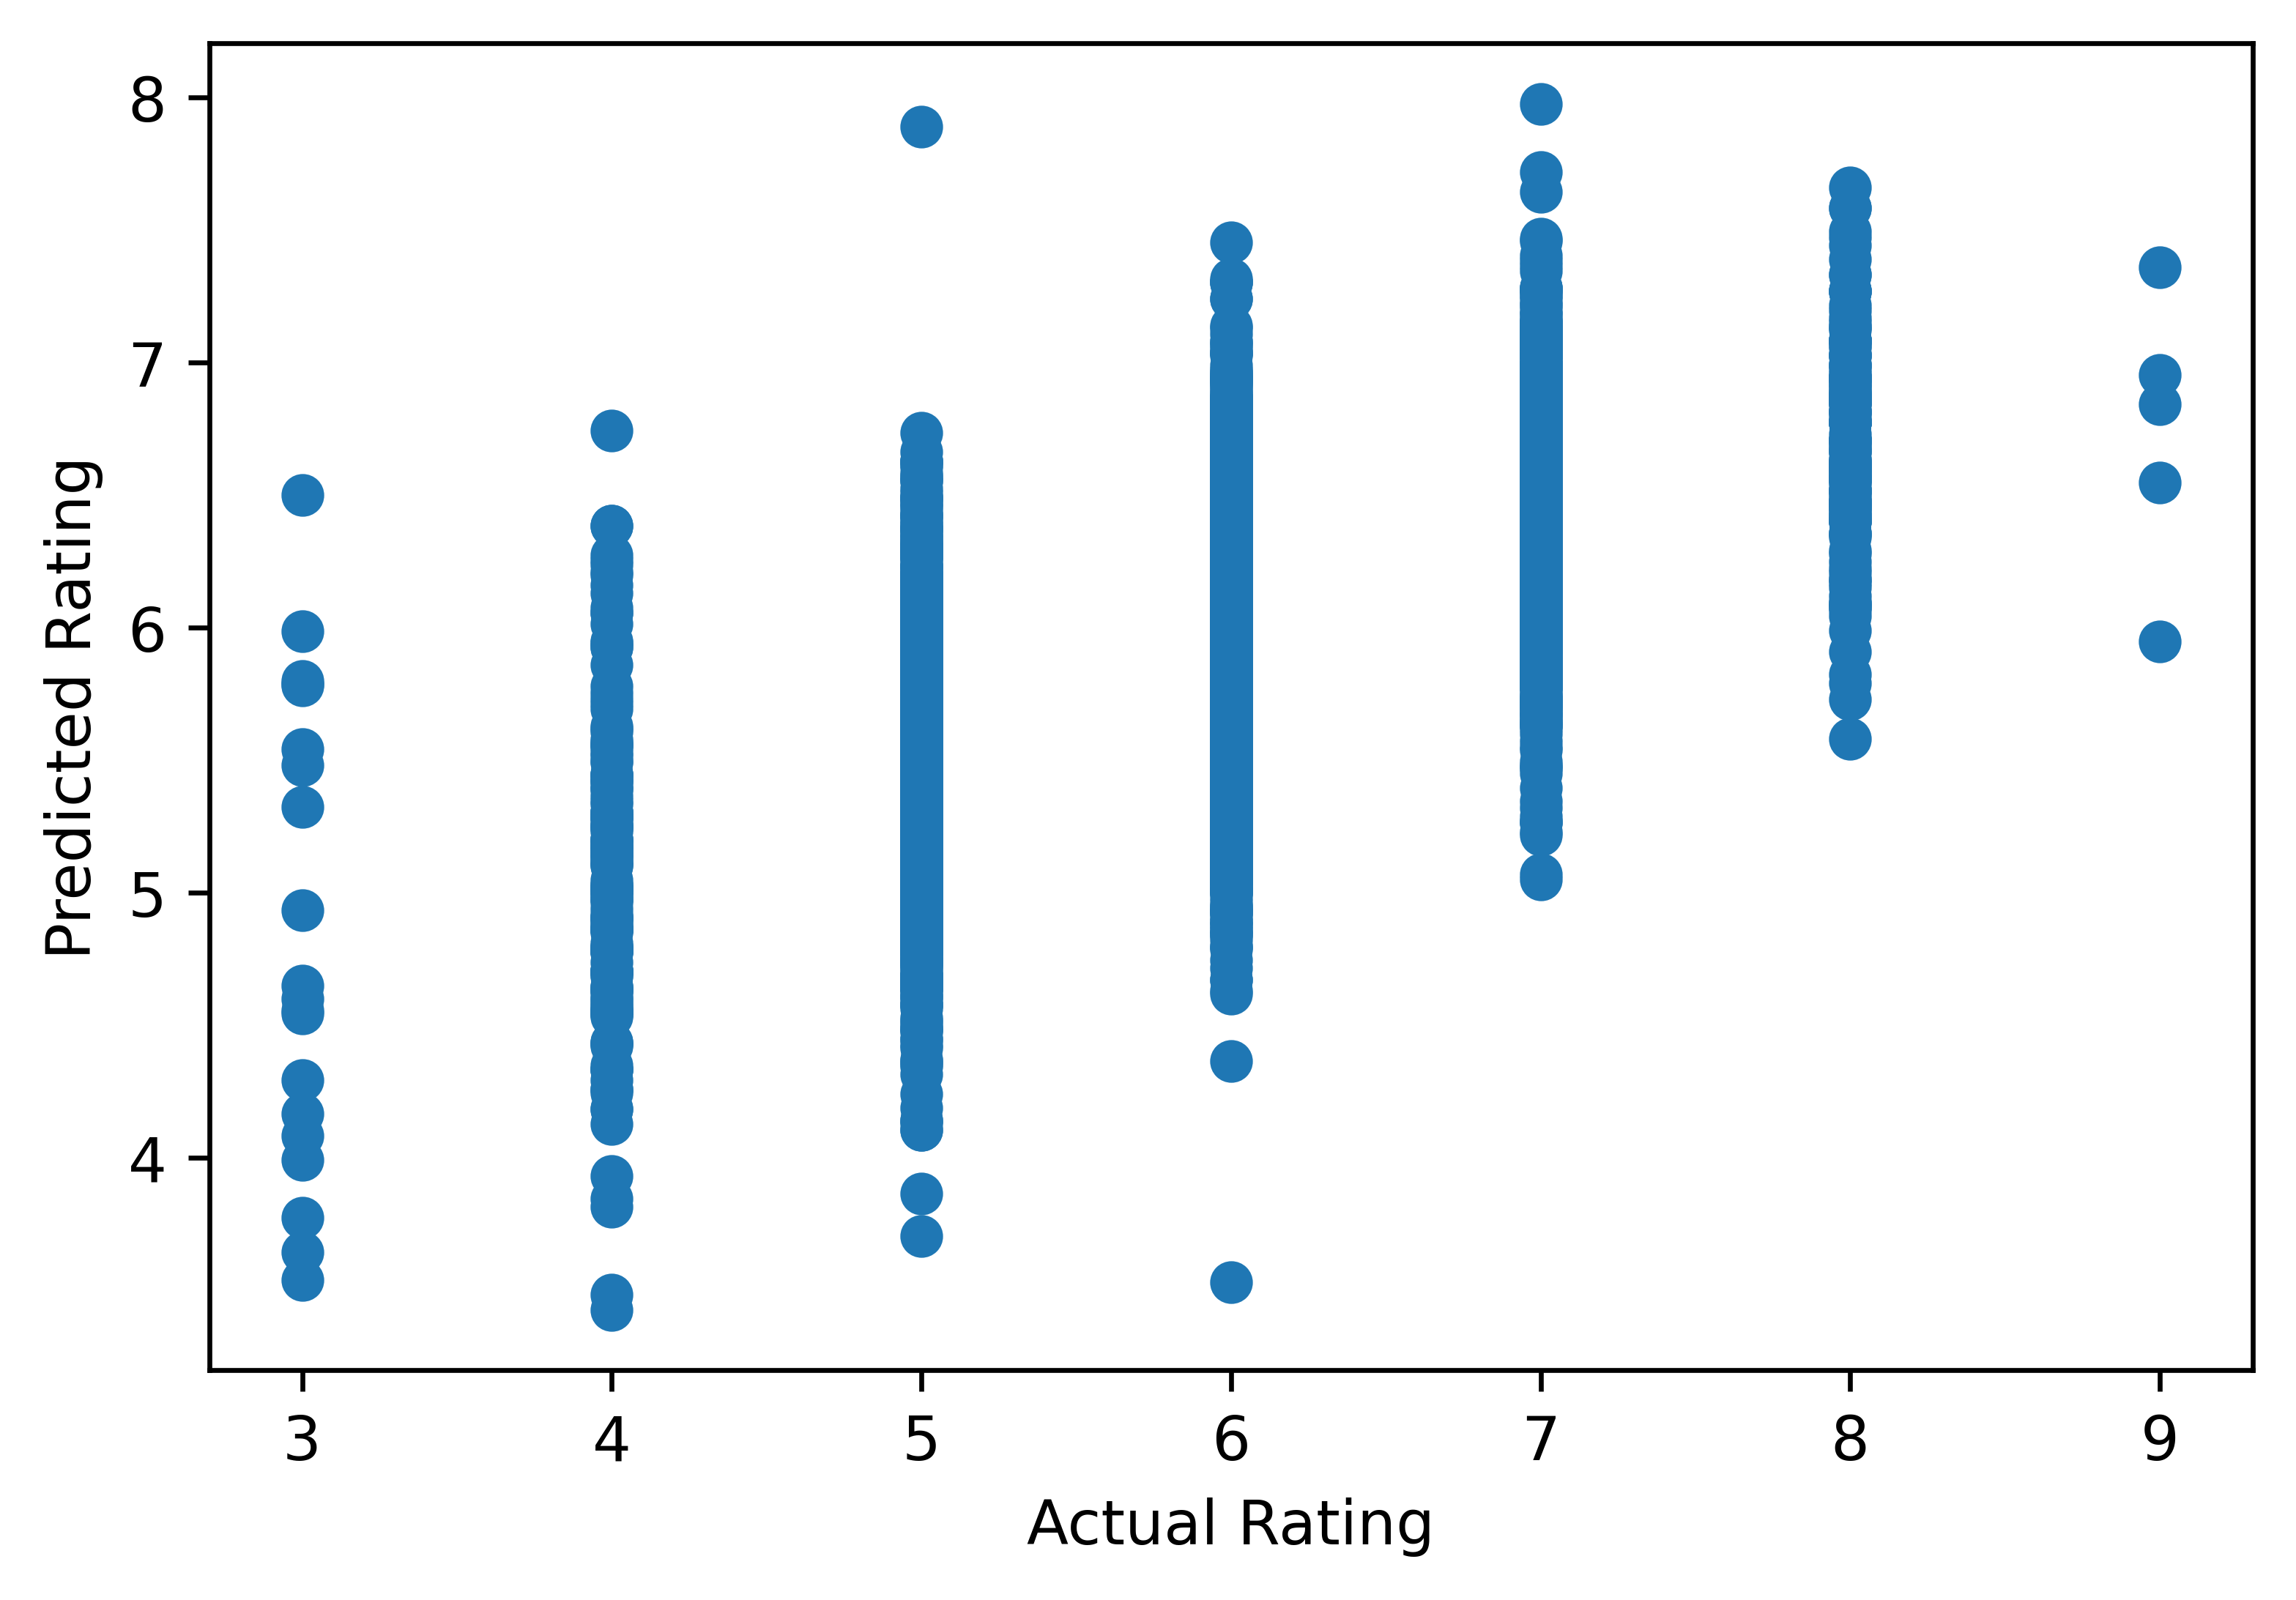

In [49]:
from matplotlib import pyplot as plt

# t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")

pred = model(data_norm)
pred = pred.detach()
targ = targ_norm
def denorm(targ_norm):
    val = (targ_norm * torch.sqrt(targ_var)) + targ_mean
    return val
plt.plot(denorm(targ).numpy(), denorm(pred).numpy(), 'o')